In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

C:\Users\Ashish\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
path = './Data/'

filename = os.path.join(path, "cancer.csv")
df = pd.read_csv(filename, na_values=['NA','?'])
df.shape


(569, 32)

In [6]:
# Encode feature vector
df.drop('id', axis=1, inplace=True)

KeyError: "['id'] not found in axis"

In [10]:
df.shape
# Encode text index

def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)


In [12]:
from sklearn import preprocessing

diagnosis = encode_text_index(df,'diagnosis')
num_classes = len(diagnosis)
num_classes


2

In [13]:
# create x and y for training
x, y = to_xy(df, 'diagnosis')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
# train and test split
x_train, x_test, y_train, y_test = train_test_split(
x, y, test_size=0.25, random_state=12)

In [15]:
# Network building
model = Sequential()
model.add(Dense(20,
               input_dim=x.shape[1],
               activation='relu'))
model.add(Dense(10,
               activation='relu'))
model.add(Dense(y.shape[1],
               activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam')
monitor = EarlyStopping(monitor='val_loss',
                       min_delta=1e-3,
                       patience=5,
                       verbose=1,
                       mode='auto')
checkpointer = ModelCheckpoint(filepath='best_wt.hdf5',
                              verbose=0,
                              save_best_only=True)
model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
         callbacks=[monitor,checkpointer],
         verbose=0,
         epochs=1000)

Epoch 00006: early stopping


In [17]:
# Load weights
model.load_weights('best_wt.hdf5')

In [19]:
# Accuracy measure
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test, axis=1)
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy:{}".format(score))

Accuracy:0.3706293706293706


In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print(cm)

# Normalize the confusion matrix
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
print(cm_normalized)


[[ 0 90]
 [ 0 53]]
[[0. 1.]
 [0. 1.]]


NameError: name 'plt' is not defined

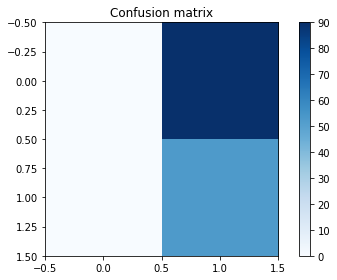

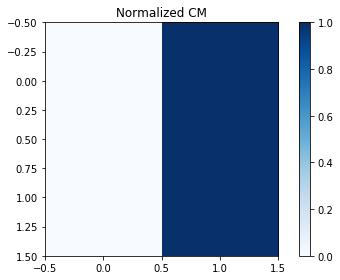

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot c_matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',
              cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.tight_layout()
    
# Plot an ROC
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
plt.figure()
plot_confusion_matrix(cm, diagnosis)

plt.figure()
plot_confusion_matrix(cm_normalized, diagnosis,
                     title='Normalized CM')
plt.show()

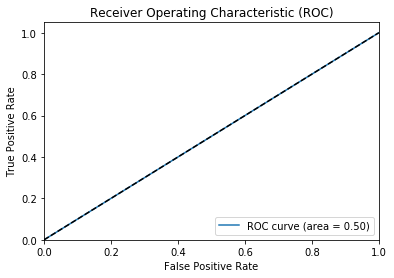

In [38]:
pred = model.predict(x_test)
pred = pred[:,1]
plot_roc(pred, y_compare)